# Estrategias de visualización espacial
## Mapeando resultados...



El propósito de este notebook es repasar algunas nociones generales sobre sistemas de coordenadas e introducirlos en las librerías más populares de visualización de datos geográficos: `Leaflet`, `Contextily` y `Folium`. 

El dataset de ejemplo que se utiliza durante ambas secciones se construyó en el notebook ```API del Servicio de Normalización de Datos Geográficos de Argentina``` que podrán encontrar en el material complementario. Para más información sobre el mismo pueden remitirse allí. 

### 1. De `data` a `geodata`!

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [3]:
fachadas_sndg = pd.read_csv('/drive/MyDrive/Gestion de ciudades/data/geolocalizacion/fachadas_sndg.csv')

In [4]:
fachadas_sndg.head(2)

seccion manzana parcela   partida     calle_nombre  calle_altura  \
0       21       2       9  429255.0  ALVAREZ, JULIAN          2531   
1       79      89      22  260164.0  LAMARCA, EMILIO          1014   

  vencimiento_certificado             direccion  \
0              2019-03-12  ALVAREZ, JULIAN 2531   
1              2019-03-30  LAMARCA, EMILIO 1014   

                                        nomenclatura        id  \
0  JULIAN ALVAREZ 2531, Comuna 14, Ciudad Autónom...  02000010   
1  EMILIO LAMARCA 1014, Comuna 11, Ciudad Autónom...  02000010   

                            nombre                  lat                 lon  \
0  Ciudad Autónoma de Buenos Aires  -34.586199585983984  -58.41378826532734   
1  Ciudad Autónoma de Buenos Aires   -34.62221828824001   -58.4827026063354   

   iddto  nombredto  
0  02098  Comuna 14  
1  02077  Comuna 11

In [5]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import geopandas as gpd
from shapely.geometry import Point

A continuación vamos a construir dos funciones. Una que nos permita obtener un objeto de tipo shapely con la geometría de nuestras coordenadas. 

El statement `try/except` se utiliza cuando queremos que un proceso no se interrumpa a pesar de existir errores en la operación que estamos ejecutando.

En nuestro caso, de haber coordenadas erróneas, nuesrtra función devolverá el string `sin coordenadas` para que podamos identificar y filtrar estos casos.

In [7]:
import numpy as np

In [8]:
def construye_geom(x,y):
    try:
        geometria = Point(float(x), float(y))#Point(np.array(float(x), float(y))) 
        return geometria
    except:
        return 'sin coordenadas'

In [9]:
def construye_gdf(df, proj=4326):
    
    geom = df.apply(lambda x: construye_geom(x.lon, x.lat), axis=1)
    df['geometry'] = geom
    localizables = df.loc[df['geometry']!='sin coordenadas']
    
    gdf = gpd.GeoDataFrame(localizables, geometry=localizables.geometry, crs=proj)
    print('Devolviendo geodataframe con {} casos perdidos'.format(len(df)-len(gdf)))
    return gdf

In [10]:
sndg_4326 = construye_gdf(fachadas_sndg)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Devolviendo geodataframe con 2369 casos perdidos


In [11]:
sndg_4326.crs.is_geographic

True

## ... definir un CRS no es reproyectar

Habrán notado que, para establecer el CRS (o sistema de coordenadas de referencia) utilicé el parámetro `proj` con el EPSG 4326 como valor por defecto. 

En el caso de nuestro dataframe la geometría proviene de un string con formato WGS84 (el conocido -34., -58 para Caba). Es por eso que hemos predefinido 4326 como CRS. 

Ahora bien, esto significa que no podemos usar otros sistemas de coordenadas? No, de hecho contamos con varias alternativas para hacerlo.

In [12]:
WKT = """PROJCS["GKBA",
        GEOGCS["International 1909 (Hayford)",
            DATUM["CAI",
                SPHEROID["intl",6378388,297]],
            PRIMEM["Greenwich",0],
            UNIT["degree",0.0174532925199433]],
        PROJECTION["Transverse_Mercator"],
        PARAMETER["latitude_of_origin",-34.6297166],
        PARAMETER["central_meridian",-58.4627],
        PARAMETER["scale_factor",0.999998],
        PARAMETER["false_easting",100000],
        PARAMETER["false_northing",100000],
        UNIT["Meter",1]]"""

In [13]:
proj4 = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'

Para [manejar sistemas de coordanas](https://geopandas.org/docs/user_guide/projections.html) geopandas trabaja con la clase `CRS` de pyproj.

Es útil que retengan que existen diversas formas de definir un CRS ([algo que cambió bastante a partir de la release 0.7.0 de geopandas](https://jorisvandenbossche.github.io/blog/2020/02/11/geopandas-pyproj-crs/)). 

Desde un código [EPSG](https://es.wikipedia.org/wiki/European_Petroleum_Survey_Group) hasta cadenas de caracteres con diversos formatos. Un buen sitio para consultar este tipo de referencias es [spatial reference](https://spatialreference.org/). 


Para ejemplificarlo, podemos explorar algún sistema de coordenadas de la Ciudad de Buenos Aires (la jurisdicción de nuestro gdf de fachadas). La Ciudad cuenta con la [proyección GKBA](https://spatialreference.org/ref/?search=GKBA&srtext=Search). Veamos cómo hacer para definirla desde formatos alternativos como un [WKT](https://spatialreference.org/ref/sr-org/7124/html/) o un [pyproj4](https://spatialreference.org/ref/sr-org/7124/proj4/), (como se muestran en las celdas de arriba).


In [14]:
from shapely import wkt
import pyproj

In [15]:
# creamos una función para cargar una geometría desde texto
def from_wkt(df, wkt_column, proj):
    df["geometry"]= df[wkt_column].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry',crs=4326)

    if proj:
      print('Reproyectando a CRS definido por el usuario')
      user_crs = pyproj.CRS.from_user_input(proj)
      gdf_user_crs = gdf.to_crs(user_crs)
      return gdf_user_crs
    else: 
      return gdf

In [16]:
# cargamos un dataframe de barrios de buenos aires
barrios_wkt = pd.read_csv('https://raw.githubusercontent.com/PyMap/datahouse/main/caba/barrios_wkt.csv')

In [17]:
barrios_wkt.str_geom.dtype

dtype('O')

In [18]:
# usamos nuestra funcion para cargar el geodataframe de barrios
bsas_gk = from_wkt(df=barrios_wkt, wkt_column='str_geom', proj=proj4)

Reproyectando a CRS definido por el usuario


In [19]:
bsas_gk.sample(1)

Unnamed: 0     BARRIO  COMUNA    PERIMETRO          AREA  OBJETO  \
0           0  CHACARITA    15.0  7724.852955  3.115707e+06  BARRIO   

                                            str_geom  \
0  POLYGON ((-58.4528200492791044 -34.59598865706...   

                                            geometry  
0  POLYGON ((100906.371 103741.599, 100829.751 10...

In [20]:
bsas_gk.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed: 0  48 non-null     int64   
 1   BARRIO      48 non-null     object  
 2   COMUNA      48 non-null     float64 
 3   PERIMETRO   48 non-null     float64 
 4   AREA        48 non-null     float64 
 5   OBJETO      48 non-null     object  
 6   str_geom    48 non-null     object  
 7   geometry    48 non-null     geometry
dtypes: float64(3), geometry(1), int64(1), object(3)
memory usage: 3.1+ KB


La diferencia entre este caso y el del geodataframe de puntos fue que en esta oportunidad primero definimos el CRS y luego reproyectamos.


In [21]:
# es decir, a este paso
bsas_4326 = from_wkt(df=barrios_wkt, wkt_column='str_geom', proj=False)

In [22]:
bsas_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
# le sumamos este (su reproyeccion!)
bsas_4326.to_crs(pyproj.CRS(WKT)).crs

<Projected CRS: PROJCS["GKBA",
        GEOGCS["International 1909  ...>
Name: GKBA
Axis Info [cartesian]:
- E[east]: Easting (Meter)
- N[north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: CAI
- Ellipsoid: intl
- Prime Meridian: Greenwich

Acá es donde tenemos que ver que **definir un CRS no equivale a reproyectar**. Y como cada CRS es un mundo, es bueno no perder de vista en qué magnitud se encuentra expresada una geometría al momento de crear un Geodataframe. 

Más concretamente, usar el parámetro `crs` de a clase GeoDataframe de geopandas no implica reproyectar una capa, sino más bien definir su aspecto.


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Devolviendo geodataframe con 2369 casos perdidos


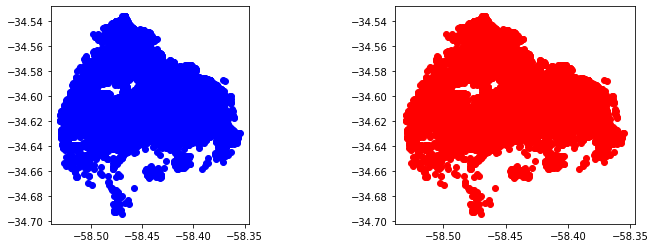

In [25]:
# definimos un CRS sin reproyectar
sndg_4326_ = construye_gdf(df=fachadas_sndg, proj=WKT)
# y comparamos
fig = plt.figure(figsize=(12,4)) 
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sndg_4326.plot(ax=ax1, color='blue')
sndg_4326_.plot(ax=ax2, color='red');

Observen que el `sndg_4326_`, cuyas coordenadas debieran estar proyectadas en un sistema proyectado (transverse mercator o gauss kruger, en nuestro caso) no esta en metros, sino en grados. 

Es común perder de vista esto (en qué CRS parecería estar expresada mi geometría, qué CRS definir y si reproyectar o no una capa). Lo que a veces puede llegar a desorientarnos ...

In [26]:
# por ejemplo, intentando reproyectar y que las magnitudes no cambien
sndg_4326_.to_crs(pyproj.CRS(WKT)).geometry.head(3)

0    POINT (-58.414 -34.586)
1    POINT (-58.483 -34.622)
2    POINT (-58.430 -34.604)
Name: geometry, dtype: geometry

In [27]:
# cuando debieran hacerlo!
sndg_4326.to_crs(pyproj.CRS(WKT)).geometry.head(3)

0    POINT (104487.612 104826.513)
1     POINT (98165.569 100831.653)
2    POINT (102991.817 102846.301)
Name: geometry, dtype: geometry

Por eso, un consejo importante a la hora de trabajar con proyecciones es estar atento con que definir el crs de una capa, no implica estar proyectándola.

Y como dijimos antes, es tal la particularidad de cada CRS (la fórmula que se usa para que una ubicación se deforme lo menos posible en su paso de elipsoidal a plano) que es posible que esta no sea compatible con el 100% de las librerías de visualización.

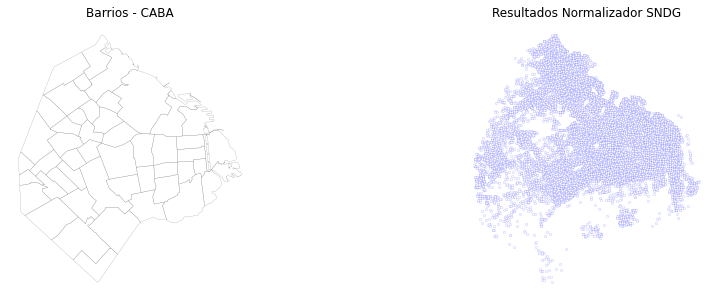

In [28]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
# los barrios de la ciudad de buenos aires
bsas_4326.geometry.boundary.plot(ax=ax1, linewidth = 0.2, edgecolor='grey')
# y nuestras fachadas
sndg_4326.plot(ax=ax2, color='white', edgecolor='blue', markersize=5, linewidth = 0.1)

ax1.set_axis_off()
ax1.set_title('Barrios - CABA')
ax2.set_axis_off()
ax2.set_title('Resultados Normalizador SNDG');

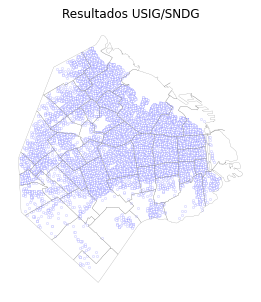

In [29]:
# Si quisieramos verlos superpuestos
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
# todo en el mismo axis
bsas_gk.geometry.boundary.plot(ax=ax, linewidth = 0.2, edgecolor='grey')
# podria reproyectar de geografico a proyectado!
sndg_4326.to_crs(bsas_gk.crs).plot(ax=ax, color='white', 
                                  edgecolor='blue', 
                                  markersize=5, linewidth = 0.1)
ax.set_axis_off()
ax.set_title('Resultados USIG/SNDG');

## 2. Librerías para ploteo de datos geográficos

### **1. Leaflet**

In [30]:
!pip install mplleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# importamos la librería
import mplleaflet

In [32]:
import matplotlib
print(matplotlib.__version__)

3.2.2


In [33]:
sndg_4326

seccion manzana parcela   partida              calle_nombre  \
0           21       2       9  429255.0           ALVAREZ, JULIAN   
1           79      89      22  260164.0           LAMARCA, EMILIO   
2           17      14      27  173288.0                 SARMIENTO   
3           42      16       1  140186.0            DIRECTORIO AV.   
4           11      65       6  442215.0                ALVEAR AV.   
...        ...     ...     ...       ...                       ...   
26484        9      68    002A  205320.0                  RIOBAMBA   
26485       29     100      11  340313.0  11 DE SEPTIEMBRE DE 1888   
26486        7      13    015C  453556.0               CORDOBA AV.   
26487        6     113    0FRA  124781.0                  NECOCHEA   
26488       97    001I       0  457343.0           GUEMES, MACACHA   

       calle_altura vencimiento_certificado                      direccion  \
0              2531              2019-03-12           ALVAREZ, JULIAN 2531   
1              1014              2019-03-30           LAMARCA, EMILIO 1014   
2              4579              2019-05-03                 SARMIENTO 4579   
3              1706              2019-06-10            DIRECTORIO AV. 1706   
4              1974              2019-06-16                ALVEAR AV. 1974   
...             ...                     ...                            ...   
26484           230                     NaN                   RIOBAMBA 230   
26485          4237                     NaN  11 DE SEPTIEMBRE DE 1888 4237   
26486          1679                     NaN               CORDOBA AV. 1679   
26487           290                     NaN                   NECOCHEA 290   
26488           322                     NaN            GUEMES, MACACHA 322   

                                            nomenclatura        id  \
0      JULIAN ALVAREZ 2531, Comuna 14, Ciudad Autónom...  02000010   
1      EMILIO LAMARCA 1014, Comuna 11, Ciudad Autónom...  02000010   
2      SARMIENTO 4579, Comuna 5, Ciudad Autónoma de B...  02000010   
3      AV DIRECTORIO 1706, Comuna 7, Ciudad Autónoma ...  02000010   
4      AV ALVEAR 1974, Comuna 2, Ciudad Autónoma de B...  02000010   
...                                                  ...       ...   
26484  RIOBAMBA 230, Comuna 3, Ciudad Autónoma de Bue...  02000010   
26485  11 DE SEPTIEMBRE DE 1888 4237, Comuna 13, Ciud...  02000010   
26486  AV CORDOBA 1679, Comuna 2, Ciudad Autónoma de ...  02000010   
26487  NECOCHEA 290, Comuna 4, Ciudad Autónoma de Bue...  02000010   
26488  MACACHA GUEMES 322, Comuna 1, Ciudad Autónoma ...  02000010   

                                nombre                  lat  \
0      Ciudad Autónoma de Buenos Aires  -34.586199585983984   
1      Ciudad Autónoma de Buenos Aires   -34.62221828824001   
2      Ciudad Autónoma de Buenos Aires   -34.60405511353745   
3      Ciudad Autónoma de Buenos Aires   -34.63066626658112   
4      Ciudad Autónoma de Buenos Aires   -34.58718262879075   
...                                ...                  ...   
26484  Ciudad Autónoma de Buenos Aires   -34.60658113931572   
26485  Ciudad Autónoma de Buenos Aires    -34.5408525447453   
26486  Ciudad Autónoma de Buenos Aires   -34.59953880166286   
26487  Ciudad Autónoma de Buenos Aires  -34.627518542106095   
26488  Ciudad Autónoma de Buenos Aires   -34.60480619885584   

                       lon  iddto  nombredto                     geometry  
0       -58.41378826532734  02098  Comuna 14  POINT (-58.41379 -34.58620)  
1        -58.4827026063354  02077  Comuna 11  POINT (-58.48270 -34.62222)  
2       -58.43008437171971  02035   Comuna 5  POINT (-58.43008 -34.60406)  
3       -58.45166254193273  02049   Comuna 7  POINT (-58.45166 -34.63067)  
4      -58.389912148004306  02014   Comuna 2  POINT (-58.38991 -34.58718)  
...                    ...    ...        ...                          ...  
26484   -58.39360237544304  02021   Comuna 3  POINT (-58.39360 -34.60658)  
26485   -58.46490456910

In [34]:
# Instanciamos el plot
ax = sndg_4326.sample(1000).plot(markersize = 50, color = "red")

# Lo visualiamos con el método display
mplleaflet.display(fig=ax.figure)

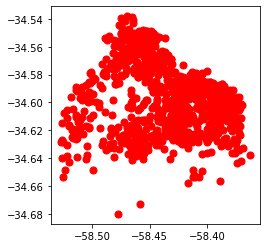

In [35]:
ax.figure

In [36]:
# También podríamos exportar nuestro mapa, así (podemos ir a buscarlo a content del drive)
sndg_4326.sample(1000).plot(markersize = 50, color = "red");
mplleaflet.show()

Esto va a generar un archivo de extensión html. Lo pueden usar para compartir algún hallazgo o información relevante.

### **2. Contextily**

Otra es [Contextily](https://contextily.readthedocs.io/en/latest/), una librería muy útil para plotear sobre un layer estático que nos de un primer pantallazo del mapa que buscamos construir.

Esto se logra con el método `add_basemap`. Ahí podemos definir distintos parametros como el `axis` donde plotear la figura,  el mapa base o source y la proyección. 

Contextily sólo funciona con las [proyecciones WGS84 (EPSG:4326) y Pseudo o Spheric Mercator (EPSG: 3857)](https://gis.stackexchange.com/questions/48949/epsg-3857-or-4326-for-googlemaps-openstreetmap-and-leaflet
). Por default, trabaja con Spheric Mercator que es un sistema de coordenadas proyectadas (sobre un plano), usado en Google Maps. Se basa en el mismo datum y elipsoide que EPSG:4326(WGS84), pero proyectando las coordenadas en un plano (en vez de sobre el elispoide). Esta es la forma que nos brinda esta libreria para trabajar en geografico y proyectado.



In [37]:
!pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# importamos la librería
import contextily as cx

In [39]:
# de esta manera podemos ver los proveedores para nuestro mapa base
cx.providers.keys()

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'Stamen', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'Gaode', 'Strava'])

In [40]:
# por ejemplo, Carto. Los tiles se encuentran bajo la llave "name"
#cx.providers.CartoDB

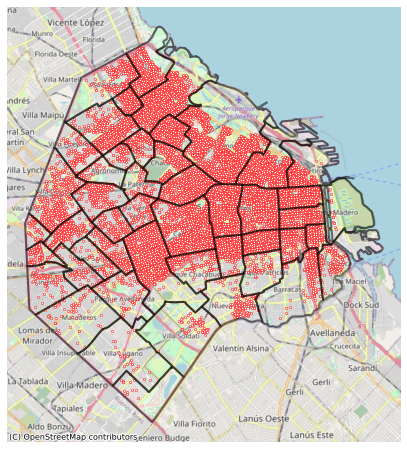

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))
bsas_4326.to_crs(epsg=3857).geometry.boundary.plot(ax=ax, linewidth = 2, 
                                                   edgecolor='black', alpha=0.5)
sndg_4326.to_crs(epsg=3857).plot(ax=ax, color='white', linewidth = 0.5, edgecolor='red', 
                                 markersize=5)
cx.add_basemap(ax, 
               #source=cx.providers.CartoDB.Positron,
               source=cx.providers.OpenStreetMap.Mapnik, 
               ) # si no reproyectabamos a 3857, deberíamos 
                 # haber dejado el parametro "crs=4326". 
                 # Vean cómo cambia la forma del mapa cuando hacen eso!
ax.set_axis_off();

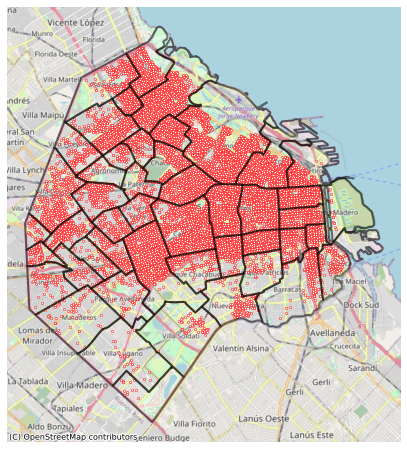

In [42]:
# a diferencia de leaflet, esto nos modifica el ax
ax.figure

### **3. Folium**

Folium es una librería que combina distintos tipos de funcionalidades. Desde controles de zoom y la posibilidad de alternar layers hasta clases que devuelven mapas de calor y coropletas.

In [43]:
# Importamos la librería
import folium

En terminos más programáticos, algo a tener en cuenta en esta librería es cómo se crean las distintas capas. Principalmente, tratando a cada fila de un gdf como una key de un Json.

In [44]:
# Creamos un mapa base
mapa = folium.Map(location=[-34.6157437, -58.4333812], 
                  zoom_start=11, 
                  control_scale=True)

# Convertimos nuestro gdf de barrios en geojson
bsas_gjson = folium.features.GeoJson(bsas_4326)
# Y lo agregamos al layer de base
bsas_gjson.add_to(mapa)

# Podemos hacer lo mismo con nuestro gdf de puntos
sndg_gjson = folium.features.GeoJson(sndg_4326.head(5), name="SNDG")
sndg_gjson.add_to(mapa);

In [45]:
mapa

In [46]:
type(sndg_gjson)

folium.features.GeoJson

In [47]:
# Acá podemos ver la estructura, cada fila es un diccionario 
sndg_gjson.data.get('features')[0]

{'bbox': [-58.41378826532734,
  -34.586199585983984,
  -58.41378826532734,
  -34.586199585983984],
 'geometry': {'coordinates': [-58.41378826532734, -34.586199585983984],
  'type': 'Point'},
 'id': '0',
 'properties': {'calle_altura': 2531,
  'calle_nombre': 'ALVAREZ, JULIAN',
  'direccion': 'ALVAREZ, JULIAN 2531',
  'highlight': {},
  'id': '02000010',
  'iddto': '02098',
  'lat': '-34.586199585983984',
  'lon': '-58.41378826532734',
  'manzana': '2',
  'nombre': 'Ciudad Autónoma de Buenos Aires',
  'nombredto': 'Comuna 14',
  'nomenclatura': 'JULIAN ALVAREZ 2531, Comuna 14, Ciudad Autónoma de Buenos Aires',
  'parcela': '9',
  'partida': 429255.0,
  'seccion': 21,
  'style': {},
  'vencimiento_certificado': '2019-03-12'},
 'type': 'Feature'}

In [48]:
from folium import plugins

In [49]:
# creemos latitudes y longitudes en formato float
sndg_4326['lat_float'] = sndg_4326['lat'].astype(float) 
sndg_4326['lon_float'] = sndg_4326['lon'].astype(float)

In [50]:
def mapa_folium(points, polygons, barrio, exporta):
  '''
  Definir docstring
  '''
  # Creamos el layer base. Lo centramos en la Ciudad de Buenos Aires
  centroide =  points.geometry.centroid
  coordenadas = [centroide.y.mean(), centroide.x.mean()]
  layer = folium.Map(location=coordenadas, 
                     tiles='CartoDB dark_matter',
                     zoom_start=11, 
                     height = 500,
                     control_scale=True)
    
  #Creamos un objeto donde agrupar todas las capas de puntos
  puntos = folium.FeatureGroup(name='Fachadas con certificado', control=True)

  #Creamos el objeto marker_cluster, como hijo del objeto puntos
  marker_cluster = plugins.MarkerCluster().add_to(puntos)
    
  #Agrupamos los marcadores en clusters, 
  for name,row in points.iterrows():
      folium.Marker([row["lat_float"], row["lon_float"]], 
                     popup='Direccion: {}'.format(row['direccion'])).add_to(marker_cluster) 
  #esto nos va a permitir usar ambos tipos de capas sobre nuestro "layer"
  layer.add_child(puntos)

  #La capa de poligonos es opcional
  if polygons is not None:
      estilo = lambda x: {'fillColor': 'yellow' if x['properties']['BARRIO']== barrio else None}
        
      pol_hover= folium.features.GeoJsonTooltip(fields=['BARRIO','COMUNA'],
                                                aliases=['Barrio:','Comuna:'])
        
      folium.GeoJson(polygons,
                     name = 'Barrios de la ciudad',
                     style_function = estilo,
                     tooltip = pol_hover
                     ).add_to(layer)
      
  # Exportar el resultado
  if exporta:
      layer.save('mapa.html')

  #Open the LayerControl of the map
  folium.LayerControl(collapsed=True).add_to(layer)
    
  return layer

In [51]:
# nos quedamos con las fachadas con vencimiento mas frecuente
sndg_4326['vencimiento_certificado_dt'] = pd.to_datetime(sndg_4326['vencimiento_certificado'])
moda = sndg_4326[sndg_4326['vencimiento_certificado_dt'].isin(sndg_4326['vencimiento_certificado_dt'].mode())]

In [52]:
mapa_folium(points=moda, polygons=bsas_4326, barrio='FLORES', exporta=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Interesante, el warning nos avisa que estamos haciendo una operacion (un promedio) sobre magnitudes correspondientes a un CRS geográfico. Lo podemos desestimar ya que esta operacion es sólo a los fines de centrar el mapa base.

Otra cuestión clave en folium es la manera en la que se van sumando capas sobre un mapa base creado a partir de la clase Map.

#### **3.1. Mapas de calor**

In [53]:
from folium.plugins import HeatMap

Otro recurso interesante con el que cuenta folium son los mapas de calor. 

In [54]:
HeatMap?

In [55]:
def mapa_de_calor(gdf, radio, inicio, fin):
    '''
    Construye un mapa de calor sobre un layer dinámico.
    ...
    Argumentos:
     gdf(GeoDataFrame): Geodataframe de puntos.
     radio (int): radio de calor para cada punto.
     inicio (int): límite inferior de la lista de coords.
     fin (int): límite superior de la lista de coords.
     
    Devuelve:
      folium.Map : mapa de calor  
    '''
    
    # Ubicamos el centro del mapa
    centroide =  gdf.geometry.centroid
    coordenadas = [centroide.y.mean(), centroide.x.mean()]
    # y creamos el layer base
    layer = folium.Map(location=coordenadas, 
                       zoom_start=11, control_scale=True)

    # Conseguimos la latitud y la longitud de cada punto con una función anónima
    x = gdf["geometry"].apply(lambda punto: punto.x)
    y = gdf["geometry"].apply(lambda punto: punto.y)

    # Convertimos esas coordenadas en una lista de tuplas
    puntos = list(zip(y, x))

    # Agregamos el mapa de calor al layer que habíamos instanciado
    HeatMap(puntos[inicio:fin], 
            radius=radio).add_to(layer)

    return layer

In [56]:
mapa_de_calor(gdf=sndg_4326, radio=15, 
              inicio=1000, fin=2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()


Lo que acabamos de hacer arriba es utilizar una función que nos permite, centrar un mapa en base a las coordenadas de nuestro geodataframe (algo que ya veníamos haciendo), y decidir sobre un listado de coordenadas cuáles queremos visualizar en un mapa de calor. Para el mismo, también podemos graduar la distancia del efecto calor respecto de cada punto. 

#### 3.2. Choropletas.

Con nuestro mapa de calor, ya pudimos identificar algunas posibles zonas de concentración. Pero qué tal si agregamos algún recurso adicional que nos permita ver dónde se aglomera nuestra variable de interés? ver con mayor granularidad si existe algún patrón de localización específico.

Para eso vamos a retomar las choropletas, pero en la manera en la que lo dispone folium.

Un mapa coroplético nos va a permitir ver la cantidad de puntos que caen dentro de unidades administrativas específicas. Y si usamos una más delgada o de nivel inferior (como los radios censales) vamos a poder ver dóndese concentran las unidades espaciales mínimas con mayor frecuencia o volumen de fachadas con certificado de conservación.

Con la clase [spatial join](https://geopandas.org/mergingdata.html#spatial-joins) vamos a poder conocer cuántos puntos caen dentro del área de cada polígono.

In [57]:
# importamos el módulo desde gepandas
from geopandas import sjoin

In [58]:
# cargamos el shapefile de radios censales
radios = gpd.read_file('/drive/MyDrive/Gestion de ciudades/data/censo_2010/caba_radios_censales.geojson')

In [59]:
radios.geometry.head()

0    POLYGON ((-58.37189 -34.59199, -58.37202 -34.5...
1    POLYGON ((-58.38593 -34.60444, -58.38575 -34.6...
2    POLYGON ((-58.37879 -34.60528, -58.37741 -34.6...
3    POLYGON ((-58.36733 -34.60562, -58.36713 -34.6...
4    POLYGON ((-58.38454 -34.60436, -58.38311 -34.6...
Name: geometry, dtype: geometry

In [60]:
radios.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
!pip install rtree
!sudo apt install libspatialindex-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [62]:
# asignamos la eitqueta del radio a cada uno de nuestros puntos
fachadas_r = gpd.sjoin(sndg_4326, radios, how='left', predicate='within')

In [63]:
fachadas_r.head(2)

seccion manzana parcela   partida     calle_nombre  calle_altura  \
0       21       2       9  429255.0  ALVAREZ, JULIAN          2531   
1       79      89      22  260164.0  LAMARCA, EMILIO          1014   

  vencimiento_certificado             direccion  \
0              2019-03-12  ALVAREZ, JULIAN 2531   
1              2019-03-30  LAMARCA, EMILIO 1014   

                                        nomenclatura        id  ...  \
0  JULIAN ALVAREZ 2531, Comuna 14, Ciudad Autónom...  02000010  ...   
1  EMILIO LAMARCA 1014, Comuna 11, Ciudad Autónom...  02000010  ...   

  vencimiento_certificado_dt index_right RADIO_ID            BARRIO COMUNA  \
0                 2019-03-12      1408.0  14_28_1           PALERMO     14   
1                 2019-03-30       558.0  11_17_6  VILLA SANTA RITA     11   

  POBLACION  VIVIENDAS  HOGARES HOGARES_NBI  AREA_KM2  
0     630.0      361.0    299.0         2.0  0.011860  
1    1175.0      470.0    408.0        12.0  0.087964  

[2 rows x 28 columns]

In [64]:
# Agrupamos la cantidad de fachadas con certificado de conservación por radio censal
fachadas_por_radio = fachadas_r.groupby(['RADIO_ID'])[['partida']].count().reset_index()

In [65]:
# Creamos un diccioanrio donde la key es el id del radio y el value la cantidad de partidas.
cant_x_radio = dict(zip(fachadas_por_radio['RADIO_ID'], fachadas_por_radio['partida']))

In [66]:
# Agregamos esta nueva información como columna adicional de nuestro shape original de radios.
radios['partidas'] = radios['RADIO_ID'].map(cant_x_radio)

In [67]:
radios[['RADIO_ID','partidas']].head()

RADIO_ID  partidas
0    1_1_1       2.0
1   1_12_1       5.0
2  1_12_10      13.0
3  1_12_11      75.0
4   1_12_2      10.0

In [68]:
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
# podemos agregar nuestra capa de radios al 'ax' que usamos con contextily
radios[['RADIO_ID','partidas','geometry']].to_crs(3857).plot(ax=ax,column='partidas', 
                                                             scheme='Natural_Breaks', 
                                                             k=3, linewidth=0.2, 
                                                             edgecolor='black', 
                                                             cmap='Reds_r', legend=True);

<Figure size 432x288 with 0 Axes>

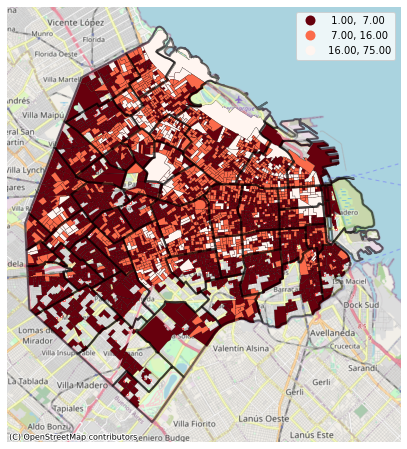

In [70]:
ax.figure

In [71]:
# reemplazamos los casos sin valor por 0 (en nuestro join espacial muchos polígonos no coincidían con ningún punto)
radios['partidas'].fillna(0,inplace=True)

In [72]:
# calculamos nuestros bins de corte (quantiles). 
qcut = list(radios['partidas'].quantile([0, 0.25, 0.5, 0.75, 1]))

In [73]:
qcut

[0.0, 2.0, 5.0, 10.0, 75.0]

En otras palabras, ordenamos nuestra serie de partidas de menor a mayor, y establecemos puntos de corte. Esto nos va a devolver radios distribuidos en cinco intervalos iguales (los que definimos en el método quantile). El percentil 20 (0), el 40 (0.25), el 60 (0.5), el 80 (0.75) y el 100 (1).


In [74]:
# vemos la cantidad de radios para la etiqueta de cada cuantil
radios['partidas_q'] = pd.qcut(radios['partidas'], 5, labels=False)

In [75]:
radios['partidas_q'].value_counts()

0    820
1    735
2    685
4    657
3    657
Name: partidas_q, dtype: int64

In [76]:
counter = 0
for i in radios['partidas_q'].value_counts():
  porcentaje = i/len(radios)*100
  print('El {}% de los casos'.format(round(porcentaje)))
  counter+=porcentaje  

El 23% de los casos
El 21% de los casos
El 19% de los casos
El 18% de los casos
El 18% de los casos


In [77]:
print("llegamos al {}%".format(int(counter)))

llegamos al 100%


In [78]:
# el primer 20% o quantil
radios.loc[radios['partidas_q']==0]['partidas'].value_counts()#.values.sum()

0.0    536
1.0    284
Name: partidas, dtype: int64

In [79]:
# el segundo (40%)
radios.loc[radios['partidas_q']==1]['partidas'].value_counts()#.values.sum()

4.0    261
2.0    250
3.0    224
Name: partidas, dtype: int64

In [80]:
# el tercero (60%)
radios.loc[radios['partidas_q']==2]['partidas'].value_counts()#.values.sum()

5.0    231
6.0    230
7.0    224
Name: partidas, dtype: int64

In [81]:
# el cuarto (80%)
radios.loc[radios['partidas_q']==3]['partidas'].value_counts()#.values.sum()

9.0     192
8.0     174
10.0    150
11.0    141
Name: partidas, dtype: int64

In [82]:
# el quinto (100%)
radios.loc[radios['partidas_q']==4]['partidas'].value_counts()#.values.sum()

12.0    96
13.0    85
14.0    78
15.0    70
16.0    57
17.0    48
18.0    39
19.0    37
20.0    30
21.0    23
22.0    14
23.0    13
26.0    12
24.0    11
25.0     6
30.0     5
28.0     5
38.0     4
36.0     3
33.0     3
27.0     2
45.0     2
31.0     2
75.0     1
49.0     1
46.0     1
58.0     1
32.0     1
43.0     1
41.0     1
40.0     1
29.0     1
35.0     1
54.0     1
37.0     1
Name: partidas, dtype: int64

In [83]:
# y obviamente, nuestro valor máximo
radios['partidas'].max()

75.0

Qué significa esto? Básicamente que el primer 20% de nuestros radios censales tendrá entre 0 y 1 partidas dentro del área delimitada por los bordes del polígono. El segundo 20%, es decir entre el 20 y el 40% de los casos tendrá un máximo de 4 y un mínimo de 2 partidas. Del 40 al 60 será entre 5 y 7, del 60 al 80% entre 8 y 11 y el último percentil (o 20% más alto) trendrá entre 12 y 75 partidas. Es decir, el más disperso.

In [84]:
# nuestros bins de corte para cada percentil o quantil
qcut

[0.0, 2.0, 5.0, 10.0, 75.0]

Ahora, vamos a utilizar la clase `Choropleth` de `Folium` para plotear nuestro agrupamiento por radio. Presten atención a la lógica general. Esta no difiere de los otros mapas que hemos visto. Primero agregar el mapa base con `.Map()`(para lo que dejamos seteado un camino que siempre nos devuelva el centro de nuestro gdf a partir de los ceontroides de las latitudes y longitudes). Y luego, ir creando los distintos objetos que iremos agregando como capas superpuestas.

In [85]:
# Instanciamos el callejero de la Ciudad, que también bajamos de Buenos Aires Data.
callejero = gpd.read_file('/drive/MyDrive/Gestion de ciudades/data/geolocalizacion/callejero.zip')

In [86]:
# Filtramos las avenidas
avenidas = callejero.loc[callejero['tipo_c']=='AVENIDA']

In [87]:
# Nos quedamos con algunas trazas ppales que vayan del centro al oeste y del centro al norte
ppales = avenidas[avenidas.nom_mapa.isin(['AV. DE MAYO', 'AV. RIVADAVIA', 'AV. CORRIENTES',
                                          'AV. SANTA FE', 'AV.CABILDO'])]

In [88]:
pp_clean = ppales.loc[(ppales['nom_mapa']=='AV. DE MAYO')|
                      ((ppales['nom_mapa']=='AV. RIVADAVIA')&
                       # filtramos rivadavia por debajo del 8000
                       (ppales['alt_izqfin']<8000)&(ppales['alt_derfin']<8000)& 
                       # y sacamos algunos tramos con altura 0
                       (ppales['alt_derfin']!=0))|
                      (ppales['nom_mapa']=='AV. CORRIENTES')|
                      (ppales['nom_mapa']=='AV. SANTA FE')|
                      (ppales['nom_mapa']=='AV.CABILDO')]

In [89]:
import warnings
warnings.filterwarnings('ignore', message='Geometry is in a geographic CRS.*')

In [90]:
# Centramos el mapa base
centroide =  radios.geometry.centroid
coordenadas = [centroide.y.mean(), centroide.x.mean()]
layer = folium.Map(location=coordenadas, 
                   zoom_start=11, 
                   height = 500,
                   control_scale=True)

# Elejimos los estilos de los tiles con los que vamos a querer plotear
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    # y los agregamos como opcion al mapa base
    folium.TileLayer(tile).add_to(layer)

# Instanciamos la coropleta
fachadas = folium.Choropleth(name='Radios censales',
                             geo_data=radios,
                             data=radios[[c for c in radios.columns if c!='geometry']],
                             columns=['RADIO_ID','partidas'],
                             key_on='properties.RADIO_ID',
                             fill_color='Reds_r', 
                             bins = qcut,
                             fill_opacity=0.6, 
                             line_opacity=0.1,
                             highlight=True,
                             legend_name='Cantidad de partidas por radio censal (CNPHV-2010)',
                             smooth_factor=1).add_to(layer)

fachadas.geojson.add_child(folium.features.GeoJsonTooltip(fields=['BARRIO','RADIO_ID','partidas'],
                                                          aliases=['Barrio:','Radio_id:','Partidas:']))


# Sumamos la capa de calles al mapa base, y le agregamos el tooltip in situ
folium.GeoJson(pp_clean,
               name='Avenidas',
               style_function=lambda x: {'weight':2,'color':'#355C7D'},
               highlight_function=lambda x: {'weight':5,'color':'yellow'},
               tooltip=folium.features.GeoJsonTooltip(fields=['nom_mapa','alt_izqfin','alt_derfin'],
                                                      aliases=['Calle:','Altura(izq):','Altura(der):']),
               smooth_factor=5.0,
              ).add_to(layer)

# También agregamos un selector de layers
folium.LayerControl().add_to(layer);

In [91]:
layer

Output hidden; open in https://colab.research.google.com to view.

Ahora sí, nuestra choropleta está lista. Qué podemos ver? Inicialmente que la concentración más alta queda denotada por el mismo modelo territorial de la ciudad. Del centro al oeste y del centro al norte (lo que se puede ver a través de las trazas de las avenidas que seleccionamos). Como dijimos anteriormente, si bien el rango es alto (de 10 a 75), nos permite ver una clara diferencia con el resto de la ciudad. Allí es donde se concentran las fachadas que han sido patrimoniadas. Un segundo paso podría ser filtrar este universo y evaluar dónde es que vuelven a concentrarse. Pero ese análisis se lo dejamos a ustedes!

# Ejercicios sugeridos

Para terminar de afianzar estos conceptos, estaría bien si:

1. Completan la docstring de la función `mapa_folim`. El objetivo es que puedan definir el tipo de objeto que se usa en cada uno de sus parámetros y visualizar cómo es que se usan en el cuerpo de la función. Pueden tomar como ejemplo la docstring de `mapa_de_calor`.

2. Realicen un diagrama o esquema sobre el funcionamiento de contextily y folium. Para el primero describan cuáles son los parametros de la clase `add_basemap` (enfoquense en comprobar qué es lo que se pasa con el objeto `ax`).
Para el segundo, su diagrama debe describir primero cómo se agrega el mapa base. Segundo, cómo se agregan capas al mismo. Realicen un ploteo libre con la capa de puntos, poligonos o lineas que deseen (pueden elegir las tres si se animan)